In [0]:
#Library imports
import pydot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.externals.six import StringIO

drive.mount('/content/gdrive')

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 8]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Data Importing & Analysis

In [0]:
#import train and test datasets
#test_data = pd.read_csv('test.csv')
#train_data = pd.read_csv('train.csv')

#new cell
with open('/content/gdrive/My Drive/Colab_Notebooks/train.csv', 'r') as f1:
  train_data = pd.read_csv(f1)
  
with open('/content/gdrive/My Drive/Colab_Notebooks/test.csv', 'r') as f2:
  test_data = pd.read_csv(f2)
  
  
with open('/content/gdrive/My Drive/Colab_Notebooks/submission.csv', 'r') as f3:
  submiss_data = pd.read_csv(f3)

#print dataset
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
#drop a few columns which should not affect survival

#Like Name, Ticket & Fare
del train_data['Name']
del train_data['Fare']
del train_data['Ticket']
del train_data['Cabin']

del test_data['Name']
del test_data['Fare']
del test_data['Ticket']
del test_data['Cabin']

train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,1,0,3,male,22.0,1,0,S
1,2,1,1,female,38.0,1,0,C
2,3,1,3,female,26.0,0,0,S
3,4,1,1,female,35.0,1,0,S
4,5,0,3,male,35.0,0,0,S


In [0]:
#assign some values for those without age
train_data['Age'].fillna(train_data['Age'].mean(), inplace=True)
test_data['Age'].fillna(test_data['Age'].mean(), inplace=True)

#delete rows without "Port of Embarkation"
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

### Data Analysis based on the selected feature

- Age Histogram

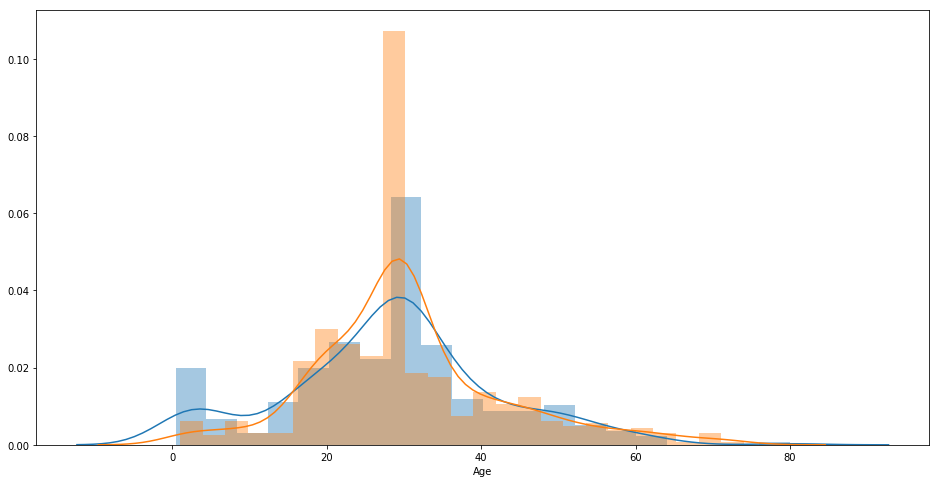

In [0]:
#Based on Age
sns.distplot(train_data.loc[train_data['Survived'] == 1]['Age'])
sns.distplot(train_data.loc[train_data['Survived'] == 0]['Age'])
plt.show()

- Based on Sex

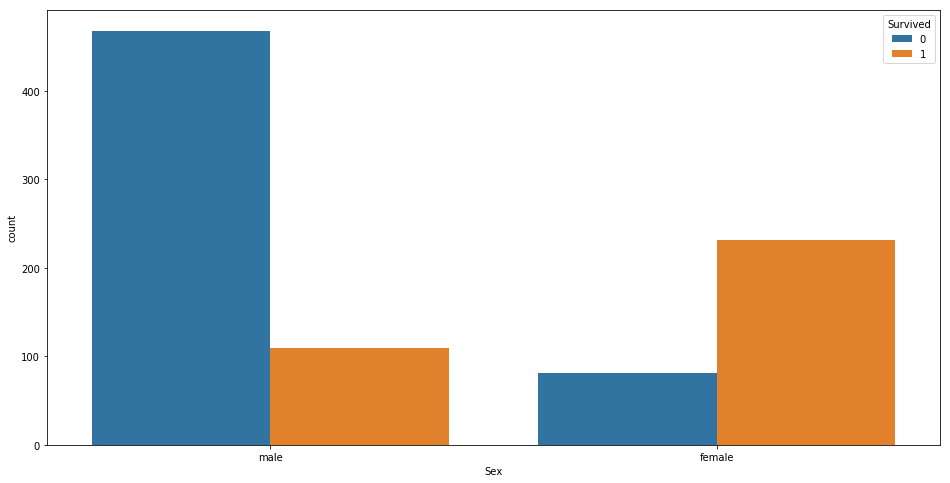

In [0]:
#Based on Sex
sns.countplot(train_data['Sex'], hue=train_data['Survived'])
plt.show()

- Economic Status

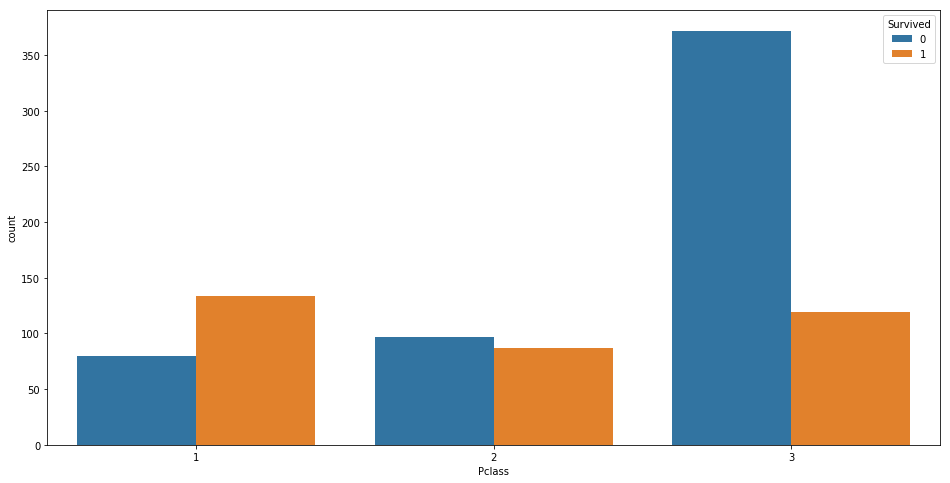

In [0]:
#Based on Pclass
sns.countplot(train_data['Pclass'], hue=train_data['Survived'])
plt.show()

- Number of Siblings

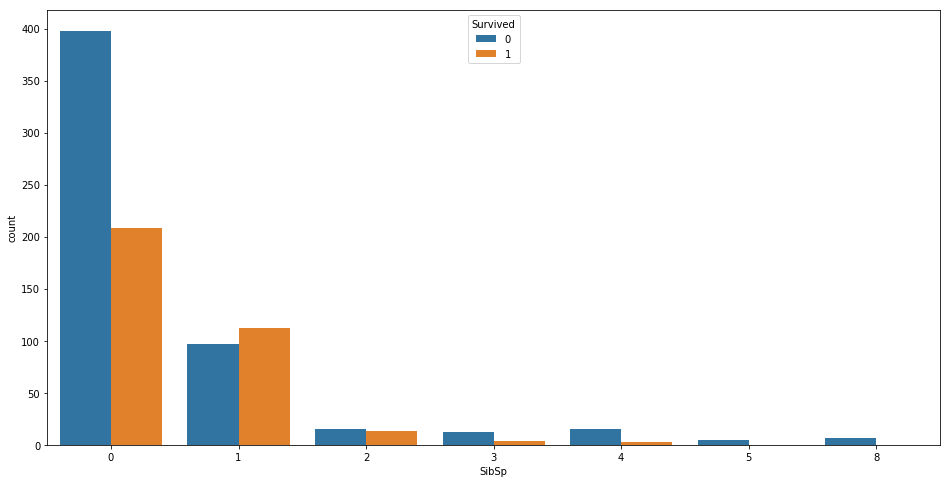

In [0]:
#Based on Sibsp
sns.countplot(train_data['SibSp'], hue=train_data['Survived'])
plt.show()

- Number of parents / children aboard the Titanic

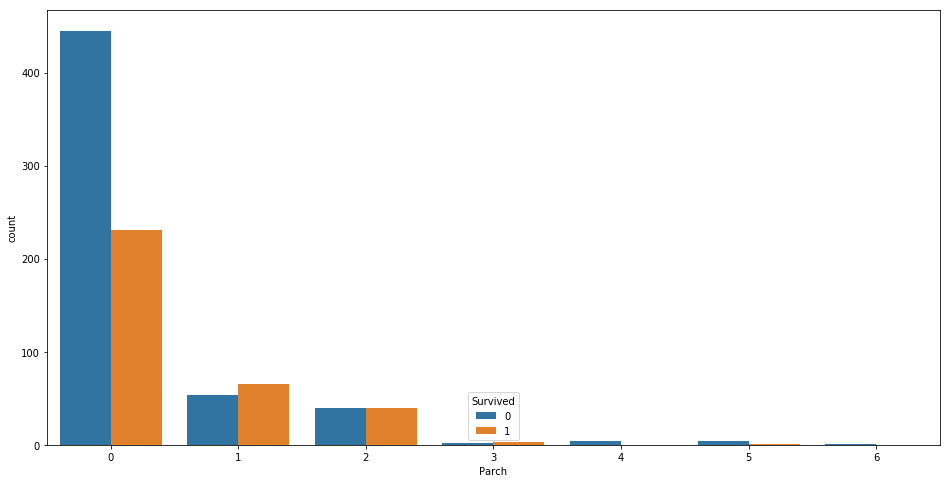

In [0]:
#Based on Parch
sns.countplot(train_data['Parch'], hue=train_data['Survived'])
plt.show()

Create Decision Tree

In [0]:
#before starting training, convert sex & embark to numerical values
train_data.replace(to_replace=['male', 'female', 'C', 'Q', 'S'], value=[0, 1, 0, 1, 2], inplace=True)
test_data.replace(to_replace=['male', 'female', 'C', 'Q', 'S'], value=[0, 1, 0, 1, 2], inplace=True)

model = tree.DecisionTreeClassifier(max_depth=5)

#training
kf = KFold(n_splits=5)
validations = []
for train, test in kf.split(train_data):
    train = train_data.iloc[train]
    test = train_data.iloc[test]
    #split datasets
    x_train = train.drop(['Survived'], axis=1)
    y_train = train['Survived']
    
    x_test = test.drop(['Survived'], axis=1)
    y_test = test['Survived']
    
    #train dataset
    model.fit(X=x_train, y=y_train)
    
    #calculate accuracy on test dataset
    y_pred = model.predict(x_test)
    validations.append(accuracy_score(y_test, y_pred))

print('validation:', np.mean(validations))

#training
x_train = train_data.drop(['Survived'], axis=1)
y_train = train_data['Survived']
print(model.fit(X=x_train, y=y_train))

validation: 0.782967313585291
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [0]:
#testing and submission
x_id = test_data['PassengerId']
y_pred = model.predict(test_data)
#pd.DataFrame({'PassengerId': x_id, 'Survived': y_pred}).to_csv('submission.csv', index=False)
pd.DataFrame({'PassengerId': x_id, 'Survived': y_pred}).to_csv('/content/gdrive/My Drive/Colab_Notebooks/submission.csv', index=False)

In [0]:
#Export tree
dot_data = StringIO() 
tree.export_graphviz(model, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph[0].write_pdf('/content/gdrive/My Drive/Colab_Notebooks/titanic.pdf')